# Unsupervised Language Learning, Lab1

## Adriaan de Vries (10795227), Verna Dankers (10761225)

Hier komt een verhaaltje over de eerste opdracht.

Before being able to run this code, please import the following libraries and set the following paths to the datasets. Afterwards, the code should run without issues.

In [1]:
# Requirements
from tqdm import tqdm
from pprint import pprint
from collections import defaultdict, Counter
from scipy.stats import spearmanr, pearsonr
from tabulate import tabulate
from gensim.models import KeyedVectors
from gensim.corpora.dictionary import Dictionary
from gensim.scripts.glove2word2vec import glove2word2vec
import numpy as np
import os
import matplotlib.pyplot as plt

# Paths to datasets
bow2_filename = "data/bow2.words"
bow5_filename = "data/bow5.words"
deps_filename = "data/deps.words"
simlex_filename = "data/SimLex-999.txt"
men_filename = "data/men/MEN_dataset_natural_form_full"
analogy_filename = "data/questions-words.txt"

# glove2word2vec(bow2_filename, bow2_filename.split(".")[0] + ".txt")
# glove2word2vec(bow5_filename, bow5_filename.split(".")[0] + ".txt")
# glove2word2vec(deps_filename, deps_filename.split(".")[0] + ".txt")
bow2 = KeyedVectors.load_word2vec_format(bow2_filename.split(".")[0] + ".txt", binary=False)
bow2.init_sims(replace=True)
bow5 = KeyedVectors.load_word2vec_format(bow5_filename.split(".")[0] + ".txt", binary=False)
bow5.init_sims(replace=True)
deps = KeyedVectors.load_word2vec_format(deps_filename.split(".")[0] + ".txt", binary=False)
deps.init_sims(replace=True)

C:\Users\Wietze\Anaconda3\envs\py34\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### 1. Collect and examine the word embeddings

In [2]:
print(deps.most_similar(positive=['reddish'])[0])
print(bow5.most_similar(positive=['cop'])[0])
print(bow2.most_similar(positive=['tissue'])[0])
# print(get_closest_word_to_word('nose', deps))
# print(get_closest_word_to_word('banana', bow5))
# print(get_closest_word_to_word('microphone', bow2))
# print(get_closest_word_to_word('moonlight', deps))
# print(get_closest_word_to_word('chocolate', bow5))
# print(get_closest_word_to_word('wording', bow2))
# print(get_closest_word_to_word('fishbowl', deps))
# print(get_closest_word_to_word('orange', bow2))

('yellowish', 0.90565025806427)
('gangster', 0.6121816039085388)
('tissues', 0.8125388026237488)


In [3]:
print(deps.most_similar(positive=['sudoku'])[0])
print(bow5.most_similar(positive=['sudoku'])[0])
print(bow2.most_similar(positive=['sudoku'])[0])

('euchre', 0.8477352857589722)
('puzzles', 0.6697622537612915)
('tic-tac-toe', 0.7244439125061035)


### 2. Collect the SimLex and MEN data to evaluate the quality of the word embeddings

In [4]:
def score_men(men, embeddings):
    scores = [[], []]
    for pair in men:
        try:
            scores[0].append(embeddings.similarity(pair[0], pair[1]))
            scores[1].append(men[pair])
        except KeyError:
            continue
    return (scores[0], scores[1])

def score_simlex(simlex, name, embeddings):
    scores = [[], []]
    for pair in simlex:
        try:
            scores[0].append(embeddings.similarity(pair[0], pair[1]))
            scores[1].append(simlex[pair][name])
        except KeyError:
            continue
    return (scores[0], scores[1])

def score_simlex_pos(simlex, name, embeddings):
    scores = [defaultdict(list), defaultdict(list)]
    for pair in simlex:
        try:
            scores[0][simlex[pair]["POS"]].append(embeddings.similarity(pair[0], pair[1]))
            scores[1][simlex[pair]["POS"]].append(simlex[pair][name])
        except KeyError:
            continue
    return (scores[0], scores[1])

simlex = dict()
men = dict()

with open(simlex_filename, 'r') as f:
    headers = f.readline().split()[2:]
    for line in f:
        line = line.split()
        simlex[(line[0], line[1])] = dict(
            [(header, float(score)) for header, score in zip(headers[1:], line[3:])]
        )
        simlex[(line[0], line[1])][headers[0]] = line[2] 

with open(men_filename, 'r') as f:
    for line in f:
        line = line.split()
        men[(line[0], line[1])] = float(line[2])

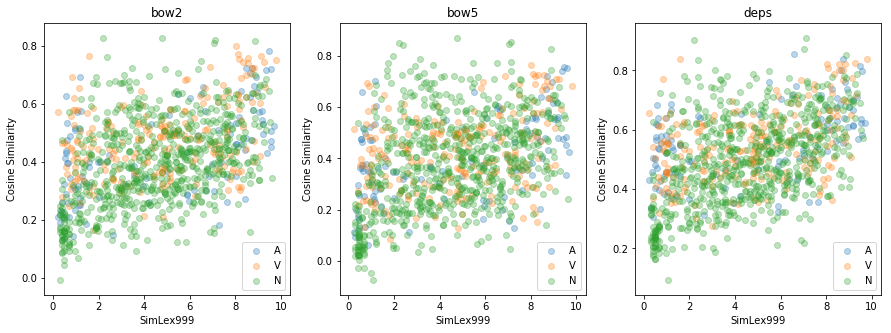

In [20]:
figure = plt.figure()
figure.set_size_inches(15, 5)
for i, (data, name) in enumerate([(bow2, 'bow2'), (bow5, 'bow5'), (deps, 'deps')]):
    yplot, xplot = score_simlex_pos(simlex, "SimLex999", data)
    
    colours = ["blue", "green", "red"]
    plt.subplot(1, 3, i+1)
    for j, pos in enumerate(xplot.keys()):
        plt.scatter(xplot[pos], yplot[pos], alpha=0.3, label=pos)
    plt.legend()
    plt.xlabel("SimLex999")
    plt.ylabel("Cosine Similarity")
    plt.title(name)
plt.show()
    

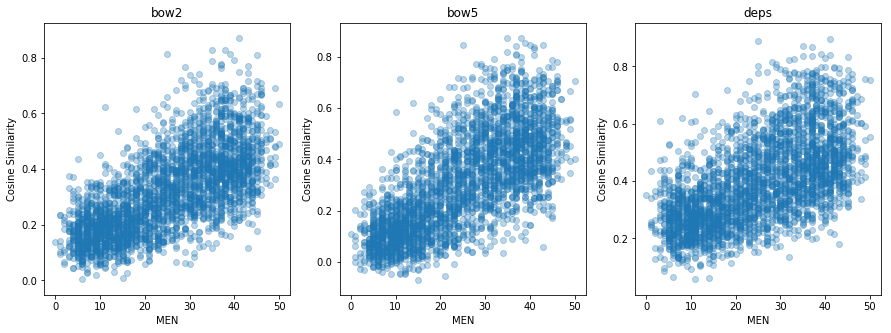

In [8]:
figure = plt.figure()
figure.set_size_inches(15, 5)
for i, (data, name) in enumerate([(bow2, 'bow2'), (bow5, 'bow5'), (deps, 'deps')]):
    yplot, xplot = score_men(men, data)
    plt.subplot(1, 3, i+1)
    plt.scatter(xplot, yplot, alpha=0.3)
    plt.xlabel("MEN")
    plt.ylabel("Cosine Similarity")
    plt.title(name)
plt.show()

### 3. Pearson's $\rho$ and Spearman's $\rho$

In [11]:
results = []
results_pos = []
for i, (data, name) in enumerate([(bow2, 'bow2'), (bow5, 'bow5'), (deps, 'deps')]):
    # MEN
    embed_results, gold = score_men(men, data)
    spearman = spearmanr(embed_results, gold)
    pearson = pearsonr(embed_results, gold)
    results.append((name, "MEN", spearman[0], spearman[1], pearson[0], pearson[1]))

    # SIMLEX
    embed_results, gold = score_simlex(simlex, "SimLex999", data)
    spearman = spearmanr(embed_results, gold)
    pearson = pearsonr(embed_results, gold)
    results.append((name, "SimLex", spearman[0], spearman[1], pearson[0], pearson[1]))
    
    # SIMLEX per POS tag
    embed_results, gold = score_simlex_pos(simlex, "SimLex999", data)
    for POS in embed_results:
        spearman = spearmanr(embed_results[POS], gold[POS])
        pearson = pearsonr(embed_results[POS], gold[POS])
        results_pos.append((name, "SimLex + {}".format(POS), spearman[0], spearman[1], pearson[0], pearson[1]))

In [14]:
print("Correlation Coefficients for all pairs in the data")
headers = ['Embeddings', 'Gold standard', 'Spearman\'s r',
           'Spearman p-value', 'Pearson\'s r', 'Pearson p-value' ]
print(tabulate(results, headers=headers, tablefmt="fancy_grid"))

print("Correlation Coefficients per POS tag")
headers = ['Embeddings', 'Gold standard', 'Spearman\'s r',
           'Spearman p-value', 'Pearson\'s r', 'Pearson p-value' ]
print(tabulate(results_pos, headers=headers, tablefmt="fancy_grid"))

Correlation Coefficients for all pairs in the data
╒══════════════╤═════════════════╤════════════════╤════════════════════╤═══════════════╤═══════════════════╕
│ Embeddings   │ Gold standard   │   Spearman's r │   Spearman p-value │   Pearson's r │   Pearson p-value │
╞══════════════╪═════════════════╪════════════════╪════════════════════╪═══════════════╪═══════════════════╡
│ bow2         │ MEN             │       0.699905 │       0            │      0.677698 │      0            │
├──────────────┼─────────────────┼────────────────┼────────────────────┼───────────────┼───────────────────┤
│ bow2         │ SimLex          │       0.414146 │       1.22681e-42  │      0.428459 │      7.993e-46    │
├──────────────┼─────────────────┼────────────────┼────────────────────┼───────────────┼───────────────────┤
│ bow5         │ MEN             │       0.723169 │       0            │      0.708236 │      0            │
├──────────────┼─────────────────┼────────────────┼────────────────────┼─────

### 4. Analogy Task

In [22]:
analogies = defaultdict(list)
with open(analogy_filename, 'r') as f:
    for line in f:
        if line[0] == ":":
            topic = line.split()[-1]
        else:
            analogies[topic].append(tuple(line.split()))

In [27]:
def analogy_task(analogies, embeddings):
    """Calculate the accuracy and MRR for embeddings on an analogy task.
    
    Args:
        analogies: dictionary with topics as keys and a list of word tuples as values
        embeddings: dictionary of word embeddings, words as keys and vectors as values
    Returns:
        float: accuracy
        float: MRR
    """
    results = []
    all_correct = 0
    all_analogies_in_vectors = 0
    for topic in analogies:
#         if topic != "capital-common-countries" and topic != "capital-world":
#             continue
        correct = 0
        analogies_in_vectors = 0
        for (a, a_star, b, b_star) in analogies[topic]:
            
            # If words with capital letters are not in the vectors, try to lowercase
            if a not in embeddings and a.lower() in embeddings:
                a = a.lower()
            if a_star not in embeddings and a_star.lower() in embeddings:
                a_star = a_star.lower()
            if b not in embeddings and b.lower() in embeddings:
                b = b.lower()
            if b_star not in embeddings and b_star.lower() in embeddings:
                b_star = b_star.lower()
            if (a not in embeddings or a_star not in embeddings or
                b not in embeddings or b_star not in embeddings):
                continue

            # Get the vector closest to the calculated analogy vector
            analogies_in_vectors += 1
            all_analogies_in_vectors += 1
            b_star_embed = embeddings[b] + (embeddings[a_star] - embeddings[a])
            b_star_embed = b_star_embed / np.linalg.norm(b_star_embed)
            closest = embeddings.similar_by_vector(b_star_embed, topn=2)
            b_star_approx = closest[0][0]
            if b_star_approx == b:
                b_star_approx = closest[1][0]
            if b_star_approx == b_star:
                correct += 1
                all_correct += 1
        results.append((topic, correct / analogies_in_vectors))
    results.append(("All topics", all_correct / all_analogies_in_vectors))
    return results

        
# sghs = KeyedVectors.load_word2vec_format("../honours/SGHS_d1000_i15_w25_annotated.bin",
#                                          binary=True)
# sghs.init_sims(replace=True)
results = analogy_task(analogies, bow2)
print(tabulate(results, headers=['Topic', 'Accuracy'], tablefmt="fancy_grid"))

╒═════════════════════════════╤════════════╕
│ Topic                       │   Accuracy │
╞═════════════════════════════╪════════════╡
│ gram9-plural-verbs          │  0.768966  │
├─────────────────────────────┼────────────┤
│ city-in-state               │  0.014998  │
├─────────────────────────────┼────────────┤
│ gram4-superlative           │  0.464962  │
├─────────────────────────────┼────────────┤
│ gram1-adjective-to-adverb   │  0.0413306 │
├─────────────────────────────┼────────────┤
│ capital-common-countries    │  0.701581  │
├─────────────────────────────┼────────────┤
│ gram8-plural                │  0.662913  │
├─────────────────────────────┼────────────┤
│ gram3-comparative           │  0.867117  │
├─────────────────────────────┼────────────┤
│ family                      │  0.70751   │
├─────────────────────────────┼────────────┤
│ capital-world               │  0.44695   │
├─────────────────────────────┼────────────┤
│ gram6-nationality-adjective │  0.57536   │
├─────────